<a id="section-one"></a>
# Introduction
**This dataset was taken from the DataCamp. It contains  32581 observations with 12 variables, which are:**

****************************************
person_age
****************************************
person_income
****************************************
person_home_ownership
****************************************
person_emp_length
****************************************
loan_intent
****************************************
loan_grade
****************************************
loan_amnt
****************************************
loan_int_rate
****************************************
loan_status(Dependent Variable/Target)
****************************************
loan_percent_income
****************************************
cb_person_default_on_file
****************************************
cb_person_cred_hist_length
****************************************
![Credit Risk Word Cloud](credit-risk-word-cloud-collage-260nw-1167365344.webp)

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, KFold
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve, cross_val_score
from sklearn.calibration import calibration_curve
import warnings
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

#adjustments
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=Warning)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [25]:
credit_data = pd.read_csv("/Users/sidhantbatra04/Downloads/Analytics work/Credit Risk/Credit Risk//cr_loan2.csv")
credit_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.00000,PERSONAL,D,35000,16.02000,1,0.59000,Y,3
1,21,9600,OWN,5.00000,EDUCATION,B,1000,11.14000,0,0.10000,N,2
2,25,9600,MORTGAGE,1.00000,MEDICAL,C,5500,12.87000,1,0.57000,N,3
3,23,65500,RENT,4.00000,MEDICAL,C,35000,15.23000,1,0.53000,N,2
4,24,54400,RENT,8.00000,MEDICAL,C,35000,14.27000,1,0.55000,Y,4


In [26]:
credit_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


<a id="section-two"></a>
# EDA

In [27]:
#Copy of the real dataset
credit_new = credit_data.copy()

In [34]:
#Descriptive Statistics

def descriptive_stats(dataframe, head = 5):
    print("#### Shape ####")
    print(dataframe.shape)
    print("#### Types ####")
    print(dataframe.dtypes)
    print("#### Head ####")
    print(dataframe.head(head))
    print("#### Tail ####")
    print(dataframe.tail(head))
    print("#### NA #####")
    print(dataframe.isnull().sum())
    print("#### Quantiles ####")
    print(dataframe.select_dtypes(include='number').quantile([0, 0.5, 0.95, 0.99, 1]).T)
descriptive_stats(credit_new)

#### Shape ####
(32581, 12)
#### Types ####
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
#### Head ####
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT          123.00000   
1          21           9600                   OWN            5.00000   
2          25           9600              MORTGAGE            1.00000   
3          23          65500                  RENT            4.00000   
4          24          54400                  RENT            8.00000   

  loan_intent loan_grade  loan_a

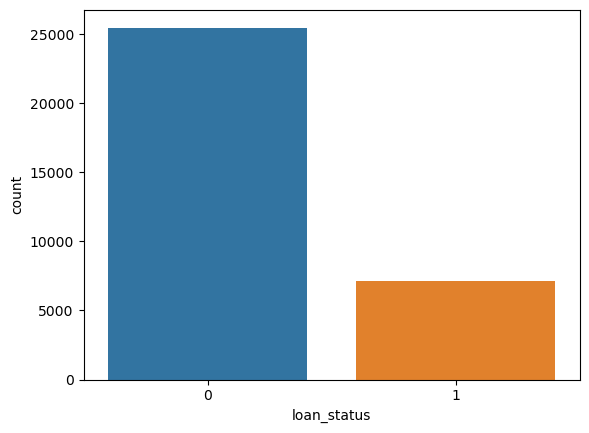

In [35]:
#Frequency Plot of the Loan Status
sns.countplot(x = "loan_status", data = credit_new)
plt.show()

In [38]:
#cross-table exloration (Pivot Table)
pd.crosstab(credit_new["person_home_ownership"], credit_new["loan_status"], values = credit_new["loan_int_rate"], aggfunc = "mean").round(2)

loan_status,0,1
person_home_ownership,,
MORTGAGE,10.06000,13.43000
OTHER,11.41000,13.56000
OWN,10.75000,12.24000
RENT,10.75000,12.97000


In [41]:
#cross table of the loan intent and loan status
pd.crosstab(credit_new["loan_intent"], credit_new["loan_status"],  margins = True)

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


In [42]:
#cross table of home ownership, loan status, and grade
pd.crosstab(credit_new["person_home_ownership"],[credit_new["loan_status"],credit_new["loan_grade"]])

loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27

In [43]:
#cross table of home ownership, loan status, and average percent income
pd.crosstab(credit_new["person_home_ownership"], credit_new["loan_status"], values=credit_new["loan_percent_income"], aggfunc="mean")

loan_status,0,1
person_home_ownership,,
MORTGAGE,0.14650,0.18488
OTHER,0.14378,0.30000
OWN,0.18001,0.29736
RENT,0.14461,0.26486


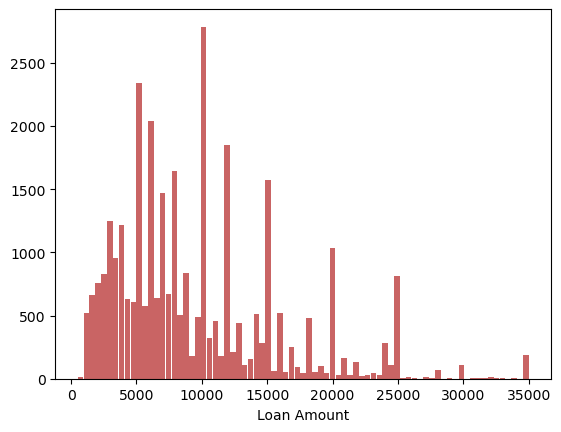

In [54]:
#Distribution of Loan Amounts

n, bins, patches = plt.hist(x = credit_new["loan_amnt"], bins = "auto", color = "firebrick", alpha = 0.7, rwidth = 0.95)
plt.xlabel("Loan Amount")
plt.show()

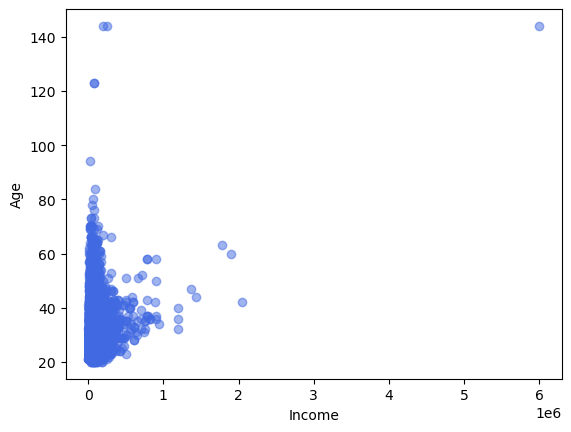

In [59]:
#scatter plot of Income against Age
plt.scatter(credit_new["person_income"], credit_new["person_age"], c = "royalblue", alpha = 0.5)
plt.xlabel("Income")
plt.ylabel("Age")
plt.show()

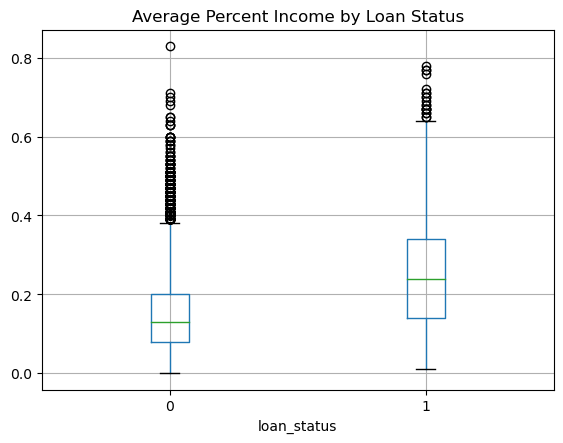

In [62]:
#box plot of the percentage income by loan status
credit_new.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

<a id="section-three"></a>
# Preprocessing

**Gathering the variables according to their data type.**

In [69]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "0"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'Categorical-columns: {len(cat_cols)}')
    print(f'Numerical-columns: {len(num_cols)}')
    print(f'Categorical-but-Cardinal: {len(cat_but_car)}')
    print(f'Numerical_but_Categorical: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(credit_new)


Observations: 32581
Variables: 12
Categorical-columns: 5
Numerical-columns: 11
Categorical-but-Cardinal: 0
Numerical_but_Categorical: 1


In [94]:
print(f'Numerical variables: {len(num_cols)}')
num_cols

Numerical variables: 11


['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

In [92]:
print(f'Categorical variables: {len(cat_cols)}')
cat_cols

Categorical variables: 5


['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'loan_status']

In [91]:
print(f'Numerical but Categorical variables: {len(num_but_cat)}')
num_but_cat
#Its the dependent variable so we're gonna ignore that.

Numerical but Categorical variables: 1


['loan_status']

<a id="section-four"></a>
# Dealing with Outliers

In [111]:
#Let's define our threshold function.
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
    num_cols = credit_new.select_dtypes(include=['number']).columns
    
for col in num_cols:
    result = check_outlier(credit_new, col)
    print(f"{col}: {'Outliers Detected' if result else 'No Outliers'}")


person_age: Outliers Detected
person_income: Outliers Detected
person_emp_length: Outliers Detected
loan_amnt: No Outliers
loan_int_rate: No Outliers
loan_status: No Outliers
loan_percent_income: No Outliers
cb_person_cred_hist_length: No Outliers


In [112]:
outlier_thresholds(credit_new, num_cols)

(person_age                       -22.50000
 person_income                -301800.00000
 person_emp_length                -27.00000
 loan_amnt                     -42200.00000
 loan_int_rate                    -14.38000
 loan_status                       -1.50000
 loan_percent_income               -0.70000
 cb_person_cred_hist_length       -20.50000
 dtype: float64,
 person_age                       93.50000
 person_income                541400.00000
 person_emp_length                45.00000
 loan_amnt                     73000.00000
 loan_int_rate                    38.42000
 loan_status                       2.50000
 loan_percent_income               1.22000
 cb_person_cred_hist_length       39.50000
 dtype: float64)

In [113]:
credit_new[credit_new["person_age"] > 93].index

Index([81, 183, 575, 747, 32297, 32416], dtype='int64')

In [114]:
#Replacing Outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in num_cols:
    replace_with_thresholds(credit_new, col)
    
for col in num_cols:
    print(col, check_outlier(credit_new, col))
    

person_age False
person_income False
person_emp_length False
loan_amnt False
loan_int_rate False
loan_status False
loan_percent_income False
cb_person_cred_hist_length False


<a id="section-five"></a>
# Missing Values

In [116]:
credit_new.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [119]:
(3116+895)/len(credit_new)*100
#12% of the dataset seems to have null values
#fill them with median

12.310856020379976

In [121]:
credit_new["person_emp_length"].fillna((credit_new["person_emp_length"].median()), inplace = True)
credit_new["loan_int_rate"].fillna((credit_new["loan_int_rate"].mean()), inplace = True)
#validation
credit_new["loan_int_rate"].isnull().sum()

0

<a id="section-six"></a>
# Rare Analysing & One-Hot Encoding
**As we are used to, we encode our data before inserting it into the machine learning model.**
**With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns.**
**Each integer value is represented as a binary vector.**


In [124]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
rare_analyser(credit_new, "loan_status", cat_cols)

#One hot encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in credit_new.columns if 10>= credit_new[col].nunique() >= 2 and col != "loan_status"]
credit_new2 = one_hot_encoder(credit_new, ohe_cols,drop_first=True)

credit_new2.columns

person_home_ownership : 4
                       COUNT   RATIO  TARGET_MEAN
person_home_ownership                            
MORTGAGE               13444 0.41263      0.12571
OTHER                    107 0.00328      0.30841
OWN                     2584 0.07931      0.07469
RENT                   16446 0.50477      0.31570


loan_intent : 6
                   COUNT   RATIO  TARGET_MEAN
loan_intent                                  
DEBTCONSOLIDATION   5212 0.15997      0.28588
EDUCATION           6453 0.19806      0.17217
HOMEIMPROVEMENT     3605 0.11065      0.26103
MEDICAL             6071 0.18634      0.26701
PERSONAL            5521 0.16945      0.19888
VENTURE             5719 0.17553      0.14810


loan_grade : 7
            COUNT   RATIO  TARGET_MEAN
loan_grade                            
A           10777 0.33078      0.09956
B           10451 0.32077      0.16276
C            6458 0.19821      0.20734
D            3626 0.11129      0.59046
E             964 0.02959      0.6441

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_Y'],
      dtype='object')

<a id="section-seven"></a>
# Creating the Model
# Multivariate Logistic Regression

In [127]:
#Multivariate Logistic Regression

y = credit_new2["loan_status"]
X = credit_new2.drop(["loan_status"], axis=1)

#Model
logit = LogisticRegression().fit(X,y)

In [128]:
logit.coef_

array([[-5.28856507e-08, -4.08285087e-05, -2.45131418e-08,
         1.07307177e-04,  8.51980711e-08,  2.61050104e-09,
        -9.09214385e-09,  8.06416681e-11, -4.02339910e-09,
         8.32952884e-09, -3.03331127e-09,  1.79934404e-09,
         1.37382404e-09, -1.18189189e-09, -3.70752493e-09,
        -5.60385763e-09, -1.39441067e-09,  1.08366295e-08,
         3.45017032e-09,  1.00622531e-09,  4.22005399e-10,
         7.13909588e-09]])

In [129]:
#Predictions
y_pred = logit.predict(X)
y_pred

array([1., 0., 1., ..., 1., 0., 0.])

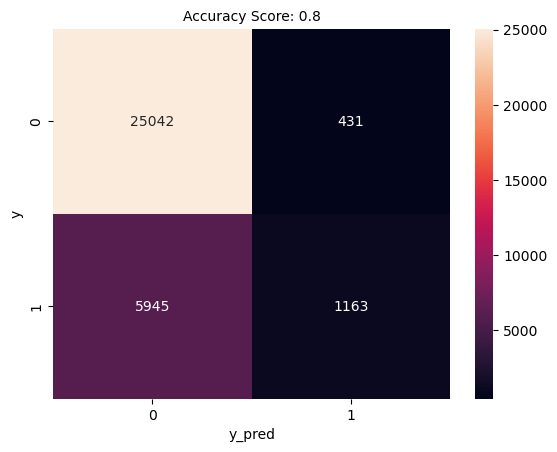

In [138]:
#Confusion Matrix
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y,y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

In [140]:
#Model Validation: Holdout, splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 1111)

In [141]:
#Building Model with Train Set
logit_model = LogisticRegression().fit(X_train, y_train)

#Predicting the test set
y_pred = logit_model.predict(X_test)

#For AUC Score()
y_prob = logit_model.predict_proba(X_test)[:, 1]

#Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89      5131
         1.0       0.71      0.17      0.28      1386

    accuracy                           0.81      6517
   macro avg       0.76      0.58      0.58      6517
weighted avg       0.79      0.81      0.76      6517



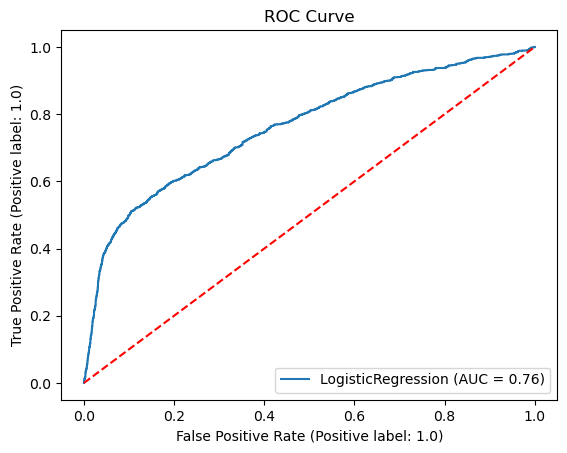

0.7607241499270343

In [148]:
#ROC Curve & ROC AUC Score

# ROC Curve
RocCurveDisplay.from_estimator(logit_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

roc_auc_score(y_test, y_prob)

In [149]:
#Model Validation: 5-Fold Cross Validation

y = credit_new2["loan_status"]
X = credit_new2.drop(["loan_status"], axis=1)

#Model
logit = LogisticRegression().fit(X,y)

In [152]:
cv_logit_acc = cross_val_score(logit, X,y,cv = 10, scoring = "accuracy")
cv_logit_f1 = cross_val_score(logit, X,y,cv = 10, scoring = "f1")
cv_logit_roc = cross_val_score(logit, X,y,cv = 10, scoring = "roc_auc")

In [153]:
cv_logit_acc.mean()
#Accuracy = 0.8025226171619755

0.8025226171619755

In [154]:
cv_logit_f1.mean()
#F-1 Score = 0.249315735453883

0.249315735453883

In [155]:
cv_logit_roc.mean()
#ROC AUC Score = 0.7690047691764843

0.7690047691764843

<a id="section-eight"></a>
# Extreme Gradient Boosting with Model Tuning

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 1111)

In [159]:
#Hyperparameter Optimization(Model Tuning)

def objective(trial):
    
    data = credit_new2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1111)
    params = {
        'objective': 'binary:logistic',
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'eval_metric' : 'error'
    }
    
    clf_gbt = xgb.XGBClassifier(**params)
    clf_gbt.fit(X_train, y_train)
    
    gbt_preds = clf_gbt.predict(X_test)
    accuracy = accuracy_score(y_test, gbt_preds)

    return (1-accuracy)

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective, n_trials=50)

    print(study.best_params)
   

[I 2025-05-25 23:57:11,564] A new study created in memory with name: no-name-16fba772-fac7-454b-bae6-c83655467e29
[I 2025-05-25 23:57:11,746] Trial 0 finished with value: 0.2126745435016112 and parameters: {'max_depth': 2, 'n_estimators': 260, 'learning_rate': 2.9224568081123716e-07}. Best is trial 0 with value: 0.2126745435016112.
[I 2025-05-25 23:57:12,029] Trial 1 finished with value: 0.2126745435016112 and parameters: {'max_depth': 3, 'n_estimators': 559, 'learning_rate': 0.0001244076059542359}. Best is trial 0 with value: 0.2126745435016112.
[I 2025-05-25 23:57:12,984] Trial 2 finished with value: 0.2126745435016112 and parameters: {'max_depth': 8, 'n_estimators': 839, 'learning_rate': 2.3441532912208707e-07}. Best is trial 0 with value: 0.2126745435016112.
[I 2025-05-25 23:57:13,658] Trial 3 finished with value: 0.2126745435016112 and parameters: {'max_depth': 7, 'n_estimators': 635, 'learning_rate': 0.00021577527284406413}. Best is trial 0 with value: 0.2126745435016112.
[I 2025

{'max_depth': 7, 'n_estimators': 279, 'learning_rate': 0.08256377663004782}


In [161]:
params = study.best_params
params['eval_metric'] = 'error'
#Training the model
clf_gbt = xgb.XGBClassifier(**study.best_params).fit(X_train, np.ravel(y_train))
#Creating probability of predictions
gbt_preds = clf_gbt.predict_proba(X_test)

#Comparison of the true and predicted values
preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['gbt_prob_default'])
true_df = y_test

print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1).head(50))

    loan_status  gbt_prob_default
0       0.00000           0.01248
1       0.00000           0.02232
2       1.00000           0.13328
3       1.00000           0.99957
4       0.00000           0.04659
5       0.00000           0.00176
6       0.00000           0.26837
7       1.00000           0.22766
8       0.00000           0.04790
9       0.00000           0.06196
10      0.00000           0.11299
11      0.00000           0.04060
12      0.00000           0.04445
13      0.00000           0.03442
14      0.00000           0.03495
15      0.00000           0.14703
16      0.00000           0.11538
17      0.00000           0.04362
18      1.00000           0.99696
19      1.00000           0.99504
20      0.00000           0.02969
21      0.00000           0.04786
22      0.00000           0.00333
23      1.00000           0.99954
24      0.00000           0.00012
25      0.00000           0.02947
26      0.00000           0.00608
27      0.00000           0.17911
28      0.0000

<a id="section-nine"></a>
# Portfolio Performance

In [162]:
#Portfolio Performance
y_prob_df = pd.DataFrame(y_prob, columns = ["lr_prob_default"])
portfolio = pd.concat([preds_df.reset_index(drop=True), y_prob_df], axis = 1)

loans = X_test["loan_amnt"]
loans.reset_index(drop=True, inplace=True)
portfolio["loan_amount"] = loans
portfolio.head()

,gbt_prob_default,lr_prob_default,loan_amount
0,0.01248,0.03778,5375
1,0.02232,0.19378,8800
2,0.13328,0.09856,8000
3,0.99957,0.48708,5175
4,0.04659,0.32120,500


In [163]:
#We assume that the loss given default(lgd) is 0,2 and it's constant.
#Creating Expected Loss Columns
lgd = 0.2
portfolio["gbt_expected_loss"] = portfolio["gbt_prob_default"] * lgd * portfolio["loan_amount"]
portfolio["lr_expected_loss"] = portfolio["lr_prob_default"] * lgd * portfolio["loan_amount"]

portfolio.head()

,gbt_prob_default,lr_prob_default,loan_amount,gbt_expected_loss,lr_expected_loss
0,0.01248,0.03778,5375,13.41827,40.60846
1,0.02232,0.19378,8800,39.28164,341.04750
2,0.13328,0.09856,8000,213.24591,157.70018
3,0.99957,0.48708,5175,1034.55615,504.12861
4,0.04659,0.32120,500,4.65914,32.12025


In [164]:
# Sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

LR expected loss:  3078857.430597511


In [165]:
# Sum of the expected loss for gbt
print('XGB expected loss: ', np.sum(portfolio['gbt_expected_loss']))

XGB expected loss:  2965881.0960164005


In [166]:
LR_expected_loss =  3108547.5195690366
GBT_expected_loss = 3044509.2289176947
print(LR_expected_loss - GBT_expected_loss)

64038.2906513419


In [167]:
# Prediction labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

#XGBoost model is superior than the logit model.

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      5131
     Default       0.97      0.73      0.83      1386

    accuracy                           0.94      6517
   macro avg       0.95      0.86      0.90      6517
weighted avg       0.94      0.94      0.93      6517



In [168]:
#Variable Importance for XGBoost

print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'person_age': 1327.0, 'person_income': 2769.0, 'person_emp_length': 1321.0, 'loan_amnt': 1430.0, 'loan_int_rate': 2066.0, 'loan_percent_income': 1338.0, 'cb_person_cred_hist_length': 790.0, 'person_home_ownership_OTHER': 20.0, 'person_home_ownership_OWN': 206.0, 'person_home_ownership_RENT': 488.0, 'loan_intent_EDUCATION': 255.0, 'loan_intent_HOMEIMPROVEMENT': 276.0, 'loan_intent_MEDICAL': 293.0, 'loan_intent_PERSONAL': 242.0, 'loan_intent_VENTURE': 212.0, 'loan_grade_B': 141.0, 'loan_grade_C': 188.0, 'loan_grade_D': 216.0, 'loan_grade_E': 161.0, 'loan_grade_F': 96.0, 'loan_grade_G': 75.0, 'cb_person_default_on_file_Y': 200.0}


In [169]:
#Cross Validation for XGBoost Model 

cv_results_accuracy= cross_val_score(clf_gbt, X,y,cv = 10, scoring = "accuracy")

In [170]:
cv_results_accuracy.mean()

0.9078610283728622

In [171]:
cv_results_f1= cross_val_score(clf_gbt, X,y,cv = 10, scoring = "f1")


In [53]:
cv_results_f1.mean()

0.7639207546323215

In [178]:
cv_results_roc= cross_val_score(clf_gbt, X,y,cv = 10, scoring = "roc_auc")
cv_results_roc.mean()

0.9059672253046376

In [180]:
#Comparing ROC AUC Scores of the Models (Hold-Out)

clf_logistic_preds = logit_model.predict(X_test)
clf_gbt_preds = clf_gbt.predict(X_test)

# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, clf_logistic_preds))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, clf_gbt_preds))

Logistic Regression AUC Score: 0.58
Gradient Boosted Tree AUC Score: 0.86


<a id="section-ten"></a>
# Credit Acceptance Rate

In [181]:
#First we need to create a dataset which contains XGBoost's prob of defaults and actual loan status.

gbt_preds = clf_gbt.predict_proba(X_test)

preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['gbt_prob_default'])
true_df = y_test

test_pred_df = pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1)

#Summary Statistics
print(test_pred_df["gbt_prob_default"].describe())

count   6517.00000
mean       0.20901
std        0.33443
min        0.00000
25%        0.01412
50%        0.05124
75%        0.17725
max        0.99998
Name: gbt_prob_default, dtype: float64


In [182]:
#Assume that we want to accept the loans which have probability below 85% .
#Threshold
threshold_85 = np.quantile(test_pred_df['gbt_prob_default'], 0.85)
threshold_85
#So we will reject the loans above our threshold rate.

0.686886966228484

In [183]:
#Applying Acceptance Rate
test_pred_df['pred_loan_status'] = test_pred_df['gbt_prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

print(test_pred_df['pred_loan_status'].value_counts())

pred_loan_status
0    5539
1     978
Name: count, dtype: int64


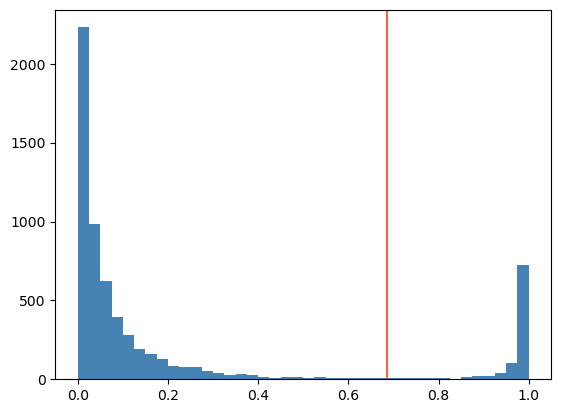

In [186]:
#Visualizing the Acceptance Quantiles

plt.hist(preds_df, color = 'steelblue', bins = 40)
plt.axvline(x = threshold_85, color = 'tomato')
plt.show()

<a id="section-eleven"></a>
# Bad Rate



In [187]:
# Subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculation of the bad rate
np.sum(accepted_loans['loan_status']) / accepted_loans['loan_status'].count()

#This means that of all the loans we've decided to accept from the test set, only 7.5% were actual defaults.

0.07492327134861888

<a id="section-twelve"></a>
# Credit Strategy and Strategy Table

In [188]:
#Creating Strategy Table
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
thresholds = []
bad_rates = []
# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculation of the threshold for the acceptance rate
    thresh = np.quantile(preds_df['gbt_prob_default'], rate).round(3)
    # Adding the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df['gbt_prob_default'], rate).round(3))
    # Reassigning the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['gbt_prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df["pred_loan_status"] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans["loan_status"]) / len(accepted_loans["loan_status"])).round(3))

# Strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0           1.00000    1.00000   0.21300
1           0.95000    0.99500   0.16800
2           0.90000    0.98300   0.12400
3           0.85000    0.68700   0.07500
4           0.80000    0.26400   0.05500
5           0.75000    0.17700   0.04500
6           0.70000    0.13100   0.03800
7           0.65000    0.10000   0.03300
8           0.60000    0.07900   0.02400
9           0.55000    0.06200   0.02000
10          0.50000    0.05100   0.01700
11          0.45000    0.04200   0.01400
12          0.40000    0.03300   0.01100
13          0.35000    0.02600   0.00700
14          0.30000    0.02000   0.00500
15          0.25000    0.01400   0.00400
16          0.20000    0.00800   0.00100
17          0.15000    0.00300   0.00000
18          0.10000    0.00100   0.00000
19          0.05000    0.00000   0.00000


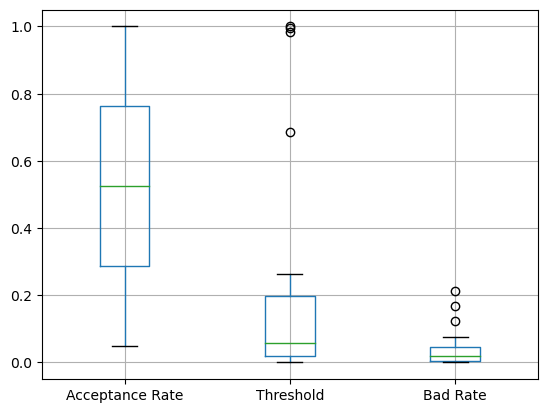

In [189]:
#Visualizing Strategy Table

strat_df.boxplot()
plt.show()

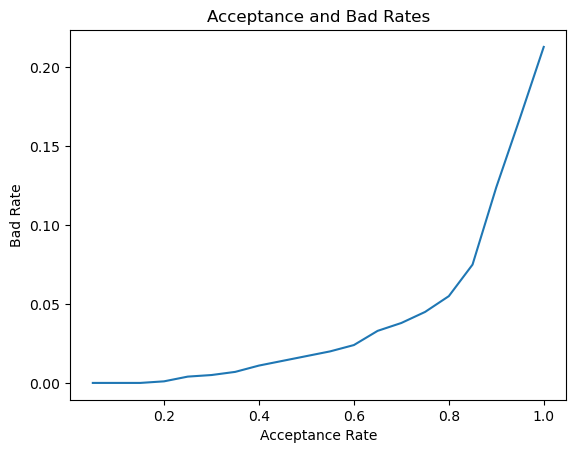

In [190]:
#Visualizing The Strategy Curve
plt.plot(strat_df["Acceptance Rate"], strat_df["Bad Rate"])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')

plt.show()

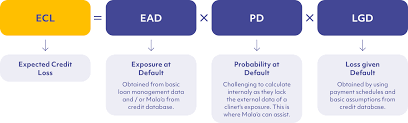

In [191]:
#Calculation of Expected Losses
strat_df["Num Accepted Loans"] = len(y_test) * strat_df["Acceptance Rate"]
strat_df["Avg Loan Amnt"] = X_test["loan_amnt"].mean()
strat_df["Estimated Value"] = ((strat_df["Num Accepted Loans"] - strat_df["Num Accepted Loans"] * strat_df["Bad Rate"]) * strat_df["Avg Loan Amnt"]) - \
                              (strat_df["Num Accepted Loans"] * strat_df["Bad Rate"] * strat_df["Avg Loan Amnt"])
strat_df.head()

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loan Amnt,Estimated Value
0,1.00000,1.00000,0.21300,6517.00000,9539.22434,35683929.75000
1,0.95000,0.99500,0.16800,6191.15000,9539.22434,39215022.45000
2,0.90000,0.98300,0.12400,5865.30000,9539.22434,42074710.20000
3,0.85000,0.68700,0.07500,5539.45000,9539.22434,44915747.81250
4,0.80000,0.26400,0.05500,5213.60000,9539.22434,44262993.00000


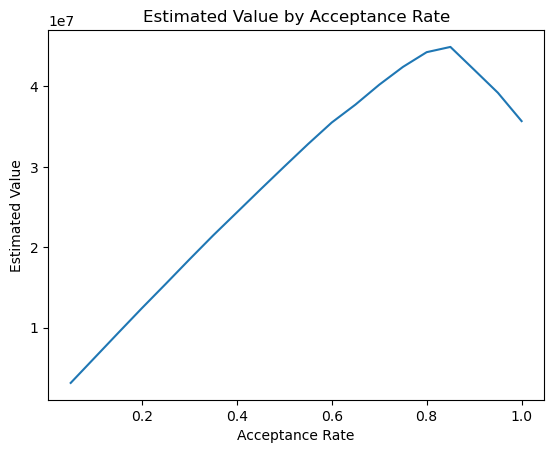

In [192]:
#Line plot of estimated value
plt.plot(strat_df["Acceptance Rate"],strat_df["Estimated Value"])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.show()


<a id="section-thirteen"></a>
# Total Expected Loss
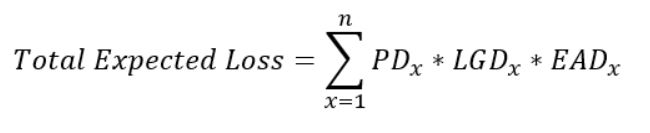

In [193]:
#Total Expected Loss
test_pred_df["loan_amnt"] = X_test["loan_amnt"]
#Assume that loss given default is 0.8.
test_pred_df["loss_given_default"] = 0.8
#Calculation of the Bank's Expected Loss
test_pred_df["expected_loss"] =  test_pred_df["gbt_prob_default"] * test_pred_df["loan_amnt"]\
                                * test_pred_df["loss_given_default"]
tot_exp_loss = round(np.sum(test_pred_df["expected_loss"]),2)

print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

Total expected loss:  $11,863,524.19


**Total expected loss:  $11,863,524.19.**
**It may seem like a lot but it would be much higher with logistic regression.**
**In conclusion, we can say that XGBoost model outperformed the logit model.**